In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Primeiro importamos nossos 2 datasets, de treino e de teste.

teste = pd.read_csv(r"C:\Users\JOAO\Downloads\test.csv")
treino = pd.read_csv(r"C:\Users\JOAO\Downloads\train.csv")

In [3]:
#display(teste.head())

In [4]:
#display(treino.head())

In [5]:
#display("(TESTE)", teste.describe())
#display("(TREINO)", treino.describe())

# Tratamento de Dados

#### Passo 1: Junção dos 2 dataframes

In [6]:
# Unimos os dataframes para tratá-los de uma só vez.

dados = pd.concat([teste,treino], ignore_index = True)

display(dados)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,8724,Technology,region_26,Bachelor's,m,sourcing,1.0,24,NaN,1,0,77.0,NaN
1,74430,HR,region_4,Bachelor's,f,other,1.0,31,3.0,5,0,51.0,NaN
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1.0,31,1.0,4,0,47.0,NaN
3,38562,Procurement,region_2,Bachelor's,f,other,NaN,31,2.0,9,0,65.0,NaN
4,64486,Finance,region_29,Bachelor's,m,sourcing,1.0,30,4.0,7,0,61.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78293,3030,Technology,region_14,Bachelor's,m,sourcing,1.0,48,3.0,17,0,NaN,0.0
78294,74592,Operations,region_27,Master's & above,f,other,1.0,37,2.0,6,0,56.0,0.0
78295,13918,Analytics,region_1,Bachelor's,m,other,1.0,27,5.0,3,0,79.0,0.0
78296,13614,Sales & Marketing,region_9,NaN,m,sourcing,1.0,29,1.0,2,0,45.0,0.0


#### Passo 2: Análise dos elementos únicos - Remoção de dados impróprios

In [7]:
# Para cada uma das features, imprimimos os elementos únicos, para propósito único de remover os dados incorretos.

features = dados.columns
for ft in features:
    print(f"{ft}: {dados[ft].unique()}, \n")

employee_id: [ 8724 74430 72255 ... 13918 13614 51526], 

department: ['Technology' 'HR' 'Sales & Marketing' 'Procurement' 'Finance' 'Analytics'
 'Operations' 'Legal' 'R&D' 'quem trouxe quenga'], 

region: ['region_26' 'region_4' 'region_13' 'region_2' 'region_29' 'region_7'
 'region_22' 'region_16' 'region_17' 'region_24' 'region_11' 'region_27'
 'region_9' 'region_20' 'region_34' 'region_23' 'region_8' 'region_14'
 'region_31' 'region_19' 'region_5' 'region_28' 'region_15' 'region_3'
 'region_25' 'region_12' 'region_21' 'region_30' 'region_10' 'region_33'
 'region_32' 'region_6' 'region_1' 'region_18' 'casa da lu na suecia'], 

education: ["Bachelor's" "Master's & above" nan 'Below Secondary'], 

gender: ['m' 'f' 'MALE' 'fEMALE' 'eu sou homem hetero homossexual!'], 

recruitment_channel: ['sourcing' 'other' 'referred'], 

no_of_trainings: [ 1. nan  2.  4.  3.  5.  7.  6.  8.  9. 10.], 

age: [    24     31     30     36     33     51     29     40     34     37
     26     49     27 

In [8]:
# Inicialmente eu pensei em substituir esses dados por NaN, mas como eles são muito poucos, decidi removê-los de cara, já
# que provavelmente seria isso que eu faria mais pra frente.

dados = dados[dados["department"] != "Legal"]
dados = dados[dados["department"] != "quem trouxe quenga"]

dados = dados[dados["region"] != "casa da lu na suecia"]

dados["gender"].replace("MALE", "m", inplace = True)
dados["gender"].replace("fEMALE", "f", inplace = True)
dados = dados[dados["gender"] != "eu sou homem hetero homossexual!"]

dados = dados[dados["age"] <= 60]
dados = dados[dados["age"] >= 18]

# Rodando novamente a célula acima, podemos ver que os dados impróprios foram removidos do dataset.

#### Passo 3: Tramento de Dados Ausentes

In [9]:
# Abaixo, podemos conferir quantos em linhas há dados faltando, para cada feature do nosso dataset. Devemos então tratar,
# quanto aos dados ausentes, as colunas referentes à educação, número de treinamentos, avaliação do ano anterior e 
# pontuação média nos treinamentos.

print(dados.isna().sum())

# Os dados ausentes na coluna referente à promoção ou não dos indivíduos se dá pelo fato
# que apenas o dataset de treino continha essa informação.

employee_id                 0
department                  0
region                      0
education                3437
gender                      0
recruitment_channel         0
no_of_trainings          6785
age                         0
previous_year_rating     5657
length_of_service           0
awards_won?                 0
avg_training_score       7338
is_promoted             23043
dtype: int64


<AxesSubplot:>

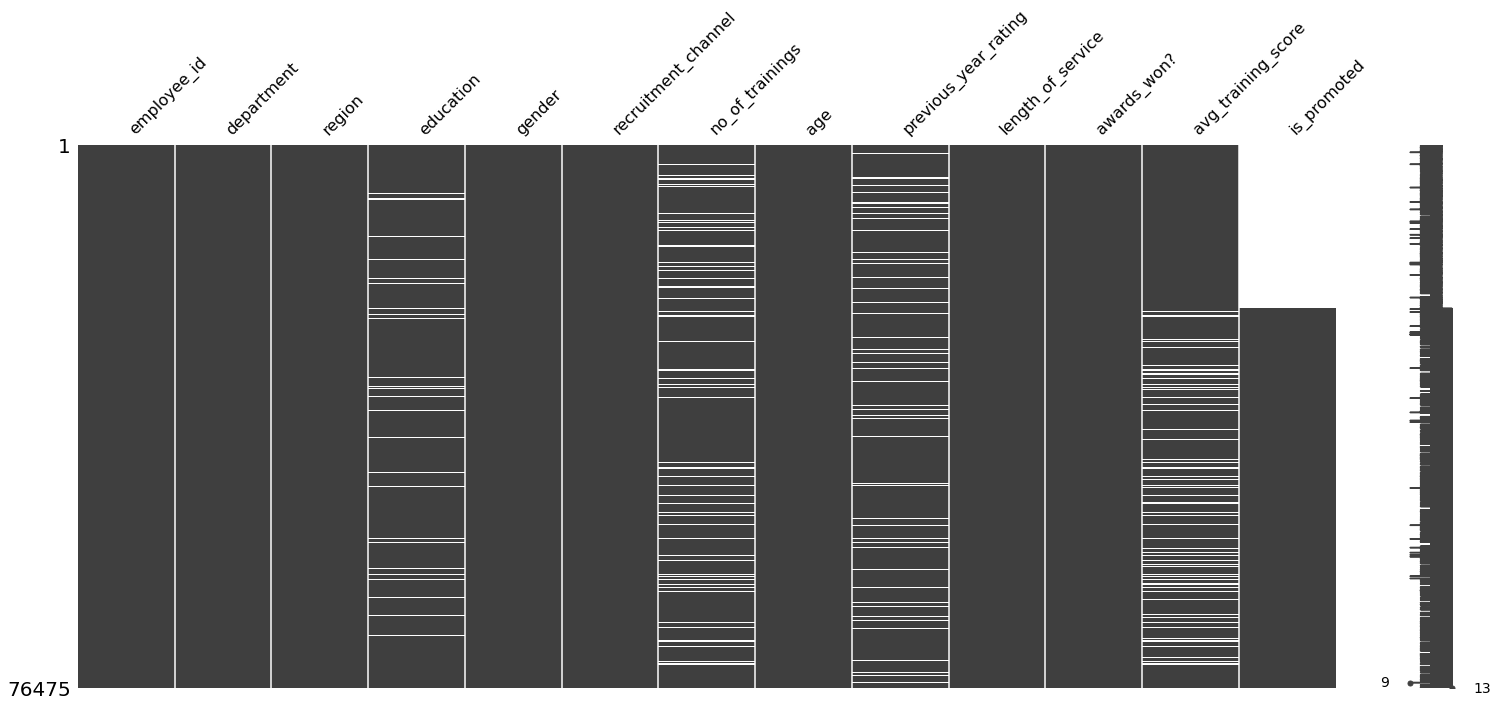

In [10]:
# Abaixo podemos observar a distribuição dos dados ausentes nas linhas de nosso dataset:

msno.matrix(dados)

In [11]:
# Substituiremos os dados ausentes da coluna education (categórica) pelo valor mais frequente (moda) da feature.

education_mode = dados["education"].mode()[0]
print("Moda education:", education_mode)
dados["education"].fillna(education_mode, inplace = True)

# Substituiremos os dados ausentes da coluna no_of_trainings (numérica) pelo inteiro mais próximo da média da feature.

no_of_trainings_mean = round(dados["no_of_trainings"].mean())
print("Média no_of_trainings:", no_of_trainings_mean)
dados["no_of_trainings"].fillna(no_of_trainings_mean, inplace = True)

# Substituiremos os dados ausentes da coluna previous_year_rating (numérica) pela mediana da feature.

previous_year_rating_median = dados["previous_year_rating"].median()
print("Mediana previous_year_rating:", previous_year_rating_median)
dados["previous_year_rating"].fillna(previous_year_rating_median, inplace = True)

# Para a quarta coluna, poderíamos optar por criar um modelo de regressão que determinasse a pontuação de cada indivíduo,
# tendo como base os valores das demais features. Entretanto, isso seria trabalhoso e fugiria da proposta do projeto. Desta
# forma, substituiremos os dados ausentes pela mediana da feature.

avg_training_score_median = dados["avg_training_score"].median()
print("Mediana avg_training_score:", avg_training_score_median)
dados["avg_training_score"].fillna(avg_training_score_median, inplace = True)

# Rodando novamente a célula acima, podemos visualizar que os dados ausentes foram preenchidos.

Moda education: Bachelor's
Média no_of_trainings: 1
Mediana previous_year_rating: 3.0
Mediana avg_training_score: 60.0


#### Passo 4: Análise de tipos de dados

In [12]:
# Nessa etapa, iremos analisar o tipo de data de nossas features e alterá-los, conforme parecer certo.

print(dados.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76475 entries, 0 to 78297
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           76475 non-null  int64  
 1   department            76475 non-null  object 
 2   region                76475 non-null  object 
 3   education             76475 non-null  object 
 4   gender                76475 non-null  object 
 5   recruitment_channel   76475 non-null  object 
 6   no_of_trainings       76475 non-null  float64
 7   age                   76475 non-null  int64  
 8   previous_year_rating  76475 non-null  float64
 9   length_of_service     76475 non-null  int64  
 10  awards_won?           76475 non-null  int64  
 11  avg_training_score    76475 non-null  float64
 12  is_promoted           53432 non-null  float64
dtypes: float64(4), int64(4), object(5)
memory usage: 8.2+ MB
None


In [13]:
# Dividimos os dados em 3 tipos:

objetos = ["employee_id","department","region"]
categorias = ["education","gender","recruitment_channel","awards_won?","is_promoted"]
inteiros = ["no_of_trainings","age","previous_year_rating","length_of_service","avg_training_score"]

In [14]:
dados[objetos] = dados[objetos].astype("object")
dados[categorias] = dados[categorias].astype("category")
dados[inteiros] = dados[inteiros].astype("int")

#### Passo 5: Nova separação dos datasets

In [15]:
# Separamos novamente o dataset de treino, a fim de se realizar a análise de dados:

comprimento_teste = dados["is_promoted"].isna().sum()

treino = dados[comprimento_teste:]

# Análise de Dados

In [16]:
# Abaixo, imprimimos, para cada categoria, de cada feature, a porcentagem de indivíduos promovidos. Dessa forma, é possível
# deduzir quais features apresentam maior impacto nas promoções.

print("Taxa de Promoção Total (dentre todos os funcionários):", 
round(100*(1 - treino["is_promoted"].value_counts(normalize = True)[0]), 2), "%.")

for caracteristica in treino.columns[1:-1]:
    valores_unicos = treino[caracteristica].unique()
    print("\n", caracteristica.upper(), "\n")
    for categoria in valores_unicos:
        dados_filtrados = treino[treino[caracteristica] == categoria]
        taxa_promocao = round(100*(1 - dados_filtrados["is_promoted"].value_counts(normalize = True)[0]), 2)
        print(categoria, "-", taxa_promocao, "%;")

Taxa de Promoção Total (dentre todos os funcionários): 8.61 %.

 DEPARTMENT 

Sales & Marketing - 7.23 %;
Operations - 8.99 %;
Technology - 10.88 %;
Analytics - 9.57 %;
R&D - 6.91 %;
Procurement - 9.64 %;
Finance - 8.24 %;
HR - 5.64 %;

 REGION 

region_7 - 10.76 %;
region_22 - 11.59 %;
region_19 - 6.07 %;
region_23 - 11.71 %;
region_26 - 6.35 %;
region_2 - 8.17 %;
region_20 - 5.78 %;
region_34 - 2.86 %;
region_1 - 9.52 %;
region_4 - 14.54 %;
region_29 - 4.37 %;
region_31 - 5.73 %;
region_15 - 7.92 %;
region_14 - 7.38 %;
region_11 - 5.72 %;
region_5 - 4.68 %;
region_28 - 11.71 %;
region_17 - 13.75 %;
region_13 - 8.79 %;
region_16 - 6.96 %;
region_25 - 12.67 %;
region_10 - 7.87 %;
region_27 - 7.6 %;
region_30 - 8.87 %;
region_12 - 6.35 %;
region_21 - 4.39 %;
region_8 - 8.12 %;
region_32 - 4.28 %;
region_6 - 4.69 %;
region_24 - 3.6 %;
region_3 - 10.76 %;
region_9 - 1.92 %;
region_33 - 2.22 %;
region_18 - 3.23 %;

 EDUCATION 

Master's & above - 9.95 %;
Bachelor's - 8.08 %;
Below Secondar

In [ ]:
# Podemos deduzir o seguinte, a partir dos dados acima:

    # 1) Indivíduos de diferentes departamentos tiveram diferentes oportunidades de promoção. Uma área que se destaca 
    # positivamente é a área de tecnologia.
    
    # 2) A região de trabalho de um indivíduo pode influenciar bastante suas oportunidades de promoção.
    
    # 3) Indivíduos com maior educação tendem a ter maior oportunidade de promoção. Essa vantagem não é muito expressiva,
    # mas está presente.
    
    # 4) Homens tendem a ser mais promovidos do que mulheres.
    
    # 5) O número de treinamentos completados não parece ser determinante.
    
    # 6) Indivíduos de certas idades apresentam maiores oportunidade de promoção.
    
    # 7) Tempo de empresa costuma valorizado na oportunidade de promoções
    
    # 8) Ganhar um prêmio aumenta substancialmente a chance de um funcionário ser promovido. O mesmo se aplica a receber
    # altas notas em avaliações de treinamento.

## Padronização e Encoding

In [17]:
# Antes de qualquer coisa, iremos unir novamente os conjuntos de dados de treino e teste, a fim de submetê-las aos
# processos de padronização e enconding.

display(dados)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,3,1,0,77,NaN
1,74430,HR,region_4,Bachelor's,f,other,1,31,3,5,0,51,NaN
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1,4,0,47,NaN
3,38562,Procurement,region_2,Bachelor's,f,other,1,31,2,9,0,65,NaN
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4,7,0,61,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78293,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3,17,0,60,0.0
78294,74592,Operations,region_27,Master's & above,f,other,1,37,2,6,0,56,0.0
78295,13918,Analytics,region_1,Bachelor's,m,other,1,27,5,3,0,79,0.0
78296,13614,Sales & Marketing,region_9,Bachelor's,m,sourcing,1,29,1,2,0,45,0.0


In [18]:
# A feature que referencia o ID dos funcionários não oferece informações úteis para o problema estudado, logo essa feature
# será removida do dataframe.

dados = dados.drop("employee_id", axis = 1)

# Ao estudar o dataset de treino, percebemos que, dentre os funcionários contemplados no conjunto de dados, homens tinham
# mais chance de promoção que mulheres. Esses dados poderiam gerar um viés no nosso algoritmo, causando mulheres serem 
# preteridas em relação a homens. Para evitar isso, essa feature será removida.

dados = dados.drop("gender", axis = 1)

In [19]:
# Abaixo consta o algoritmo para padronização de dados numéricos de nosso dataset:

for caracteristica in dados.columns[:-1]:
    if dados[caracteristica].dtypes == "int":
        x_max = dados[caracteristica].max()
        x_min = dados[caracteristica].min()
        dados[caracteristica] = (dados[caracteristica] - x_min)/(x_max - x_min)

In [20]:
# Abaixo consta o código para o encoding de dados categóricos de nosso dataset:

pd.set_option("display.max_columns", None)

promocao = dados.iloc[:, -1:]
dados = dados.iloc[:, :-1]

hot_encoding = pd.get_dummies(dados)
dados = hot_encoding

In [34]:
# Visulização de nosso dataset após todas as alterações feitas

display(dados)

,no_of_trainings,age,previous_year_rating,length_of_service,avg_training_score,department_Analytics,department_Finance,department_HR,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_1,region_region_10,region_region_11,region_region_12,region_region_13,region_region_14,region_region_15,region_region_16,region_region_17,region_region_18,region_region_19,region_region_2,region_region_20,region_region_21,region_region_22,region_region_23,region_region_24,region_region_25,region_region_26,region_region_27,region_region_28,region_region_29,region_region_3,region_region_30,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,awards_won?_0,awards_won?_1
0,0.0,0.100,0.50,0.000000,0.633333,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
1,0.0,0.275,0.50,0.111111,0.200000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0
2,0.0,0.275,0.00,0.083333,0.133333,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
3,0.0,0.275,0.25,0.222222,0.433333,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
4,0.0,0.250,0.75,0.166667,0.366667,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78293,0.0,0.700,0.50,0.444444,0.350000,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
78294,0.0,0.425,0.25,0.138889,0.283333,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
78295,0.0,0.175,1.00,0.055556,0.666667,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
78296,0.0,0.225,0.00,0.027778,0.100000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0


In [44]:
teste = dados[:comprimento_teste]
treino = dados[comprimento_teste:]

promocao_treino = promocao[comprimento_teste:]

In [45]:
# Preparação para a aplicação do algoritmo knn:

X_test = teste
X_val = validacao = treino[:10000]
X_train = treino = treino[10000:]

y_val = promocao_treino[:10000]
y_train = promocao_treino[10000:]

In [55]:
# Procuramos pelo k-ótimo, para o qual a acurácia de nosso modelo de machine learning será a máxima possível. Para isso 
# comparamos os resultados obtidos para diferentes valores de k com dados de validação já conhecidos.

for k in range(1,20):
    modelo = KNeighborsClassifier(n_neighbors = k)
    modelo.fit(X_train, y_train.values.ravel())
    y_predict = modelo.predict(X_val)
    if k == 1:
        acuracia_maxima = accuracy_score(y_val, y_predict)
        k_otimo = k
    else:
        acuracia = accuracy_score(y_val, y_predict)
        if acuracia > acuracia_maxima:
            acuracia_maxima = acuracia
            k_otimo = k

In [57]:
# Chegamos à seguinte acurácia máxima:

print(k_otimo)
print(acuracia_maxima)

7
0.9147


In [59]:
# Finalmente, colocamos nosso modelo em funcionamento para determinar a promoção (ou não) dos funcionários de nosso dataset
# de teste.

modelo_otimo = KNeighborsClassifier(n_neighbors = 7)
modelo_otimo.fit(X_train, y_train.values.ravel())
y_predict = modelo.predict(X_test)

In [61]:
print(y_predict)

[0. 0. 0. ... 0. 0. 0.]
